In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ssm.models import HMM

# Introduction
Drift-diffusion models are common models of choice behavior and neural activity in 2AFC decision tasks (Gold and Shadlen, *Annu. Rev. Neurosci.* 2007; Ratcliff, *Neural Computation* 2008), where they are typically fit to the set of choices and reaction times in an experiment. Recent work has fit neural instantiations of the DDM to spiking responses (Latimer et al., *Science* 2015; Zoltowski et al., *bioRxiv* 2018). While many formulations of DDM-like models exist in the literature, here we aim to describe how such models can be instantiated as state-space models. We can then leverage the flexibility of this framework to generalize the models in interesting ways and fit them to neural activity.

# Make a simple drift-diffusion model (DDM)  

The state is a one dimensional variable $x_t \in \mathbb{R}$. There is a discrete state $z_t \in \{\mathsf{ramp}, \mathsf{left bound}, \mathsf{right bound}\}$ that indicates whether the continuous state has reached its threshold (bound). Let $u_t \in \mathbb{R}$ be the input, which specifiy the amount of evidence to the left or right choice, which governs the dynamics of $x_t$. 

Model:
$$
\begin{align*}
z_t &\sim p(x_{t-1}) \\
x_t &= x_{t-1} + V_{z_t} u_t + \epsilon_t 
\end{align*}
$$
where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ and the input weights are constrained such that
$$
\begin{align*}
V_{\mathsf{ramp}} &= \beta, \\
V_{\mathsf{left bound}} = V_{\mathsf{right bound}} &= 0.
\end{align*}
$$
The discrete transition probabilities are,
$$
\begin{align*}
\log p(z_t = \textsf{left bound} \mid x_{t-1}) &\propto x_{t-1} - 1 \\
\log p(z_t = \textsf{ramp} \mid x_{t-1}) &\propto 0 \\
\log p(z_t = \textsf{right bound} \mid x_{t-1}) &\propto -x_{t-1} - 1
\end{align*}
$$

In [3]:
hmm = HMM(K=3, D=1, M=1, observations="diagonal_ar", transitions="recurrent_only")

In [4]:
hmm.init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])

# All the states have dynamics matrix of 1 (identity) and bias of 0
hmm.observations.As = np.ones((3, 1, 1))
hmm.observations.bs = np.zeros((3, 1))
hmm.observations._log_sigmasq = np.log(np.array([1e-5, 1e-3, 1e-5])).reshape((3, 1))
hmm.observations.mu_init = np.zeros((3, 1))
hmm.observations._log_sigmasq_init = np.log(.01 * np.ones((3, 1)))

# They only differ in their input 
beta = 1
hmm.observations.Vs[0] = 0       # left bound
hmm.observations.Vs[1] = beta    # ramp
hmm.observations.Vs[2] = 0       # right bound

In [5]:
w = 100
hmm.transitions.Ws = np.zeros((3, 1))
hmm.transitions.Rs = np.array([w, 0, -w]).reshape((3, 1))
hmm.transitions.r = np.array([-w, 0, -w])

In [6]:
# Sample state trajectories
T = 100
u = .015 * np.ones((T, 1))

samples = [hmm.sample(T, input=u) for _ in range(100)]
zs, xs = zip(*samples)

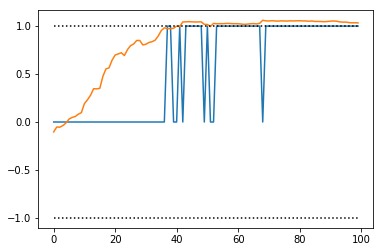

In [7]:
i = 4
plt.plot(1 - zs[i])
plt.plot(xs[i][:, 0])
plt.plot(np.ones(T), ':k')
plt.plot(-np.ones(T), ':k')

Text(0,0.5,'$x(t)$')

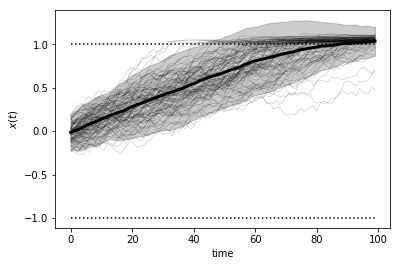

In [8]:
x_mean = np.mean(xs, axis=0)[:, 0]
x_std = np.std(xs, axis=0)[:, 0]

plt.fill_between(np.arange(T), x_mean-2*x_std, x_mean+2*x_std, color='k', edgecolor="none", alpha=0.2)
plt.plot(x_mean, '-k', lw=3)
for x in xs:
    plt.plot(x, '-k', lw=.5, alpha=.25)

plt.plot(np.ones(T), ':k')
plt.plot(-np.ones(T), ':k')

plt.xlabel("time")
plt.ylabel("$x(t)$")

# Try to fit the model

In [9]:
from ssm.core import BaseHMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import _Transitions, RecurrentOnlyTransitions
from ssm.observations import _Observations, AutoRegressiveDiagonalNoiseObservations

class DDMObservations(AutoRegressiveDiagonalNoiseObservations):
    def __init__(self, K, D, M=1, lags=1, beta=1.0, sigmas=1e-3 * np.ones((3, 1))):
        assert K == 3
        assert D == 1
        assert M == 1
        super(DDMObservations, self).__init__(K, D, M)
        
        # The only free parameters of the DDM are the ramp rate...
        self.beta = beta
        
        # and the noise variances, which are initialized in the AR constructor
        self._log_sigmasq = np.log(sigmas)
        
        # Set the remaining parameters to fixed values
        self._As = np.ones((3, 1, 1))
        self.bs = np.zeros((3, 1))
        self.mu_init = np.zeros((3, 1))
        self._log_sigmasq_init = np.log(.01 * np.ones((3, 1)))

        # They only differ in their input 
        self.Vs[0] = 0            # left bound
        self.Vs[1] = self.beta    # ramp
        self.Vs[2] = 0            # right bound
        
    @property
    def params(self):
        return self.beta, self._log_sigmasq
        
    @params.setter
    def params(self, value):
        self.beta, self._log_sigmasq = value
        mask = np.reshape(np.array([0, 1, 0]), (3, 1, 1))
        self.Vs = mask * self.beta
        
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        _Observations.m_step(self, expectations, datas, inputs, masks, tags, **kwargs)
        

# Do the same for the transition model
class DDMTransitions(RecurrentOnlyTransitions):
    def __init__(self, K, D, M=0, scale=100):
        assert K == 3
        assert D == 1
        assert M == 1
        super(DDMTransitions, self).__init__(K, D, M)

        # Parameters linking past observations to state distribution
        self.Ws = np.zeros((3, 1))
        self.Rs = np.array([scale, 0, -scale]).reshape((3, 1))
        self.r = np.array([-scale, 0, -scale])

    @property
    def params(self):
        return ()
    
    @params.setter
    def params(self, value):
        pass
    
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass
    
    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        pass


def DDM(beta=1.0, sigmas=np.array([[1e-5], [1e-3], [1e-5]])):
    K, D, M = 3, 1, 1
    
    # Build the initial state distribution, the transitions, and the observations
    init_state_distn = InitialStateDistribution(K, D, M)
    init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
    transition_distn = DDMTransitions(K, D, M)
    observation_distn = DDMObservations(K, D, M, beta=beta, sigmas=sigmas)
    
    return BaseHMM(K, D, M, init_state_distn, transition_distn, observation_distn)

In [10]:
ddm = DDM()

# Sample state trajectories
T = 100
N_samples = 100

us = []
zs = []
xs = []

for smpl in range(N_samples):
    u = -.025 + .05 * np.random.rand() * np.ones((T, 1))
    z, x = ddm.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

Text(0,0.5,'$x(t)$')

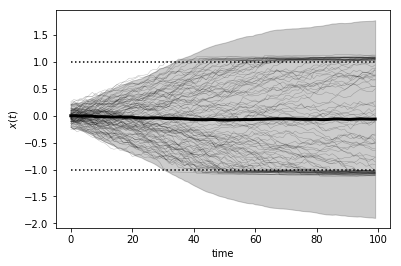

In [11]:
x_mean = np.mean(xs, axis=0)[:, 0]
x_std = np.std(xs, axis=0)[:, 0]

plt.fill_between(np.arange(T), x_mean-2*x_std, x_mean+2*x_std, color='k', edgecolor="none", alpha=0.2)
plt.plot(x_mean, '-k', lw=3)
for x in xs:
    plt.plot(x, '-k', lw=.5, alpha=.25)

plt.plot(np.ones(T), ':k')
plt.plot(-np.ones(T), ':k')

plt.xlabel("time")
plt.ylabel("$x(t)$")

In [12]:
test_ddm = DDM(beta=0.0, sigmas=np.ones((3, 1)))
# test_ddm = DDM()

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

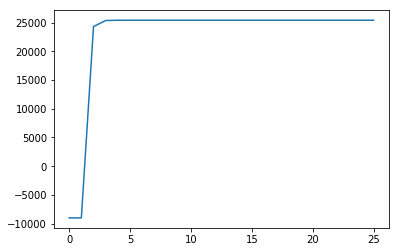

In [13]:
lls = test_ddm.fit(xs, inputs=us, num_em_iters=25)

plt.plot(lls)

In [14]:
print(ddm.observations.beta)
print(ddm.observations.sigmasq)

1.0
[[1.e-05]
 [1.e-03]
 [1.e-05]]


In [15]:
print(test_ddm.observations.beta)
print(test_ddm.observations.sigmasq)

0.9565798162990978
[[9.19042459e-06]
 [1.01092261e-03]
 [1.02390504e-05]]


In [16]:
print("True: ", ddm.log_likelihood(xs, inputs=us))
print("Test: ", test_ddm.log_likelihood(xs, inputs=us))

True:  25434.37079622355
Test:  25437.858300222517


# Try a latent version of the DDM with linear emissions

In [17]:
from ssm.emissions import _LinearEmissions, GaussianEmissions, PoissonEmissions
from ssm.core import BaseSwitchingLDS

class DDMGaussianEmissions(GaussianEmissions):
    def __init__(self, N, K, D, M=0, single_subspace=True):
        super(DDMGaussianEmissions, self).__init__(N, K, D, M=M, single_subspace=single_subspace)
        # Make sure the input matrix Fs is set to zero and never updated
        self.Fs *= 0

    # Construct an emissions model
    @property
    def params(self):
        return self._Cs, self.ds, self.inv_etas

    @params.setter
    def params(self, value):
        self._Cs, self.ds, self.inv_etas = value


def LatentDDM(N, beta=1.0, sigmas=np.array([[1e-5], [1e-3], [1e-5]])):
    K, D, M = 3, 1, 1
    
    # Build the initial state distribution, the transitions, and the observations
    init_state_distn = InitialStateDistribution(K, D, M)
    init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
    transition_distn = DDMTransitions(K, D, M)
    dynamics_distn = DDMObservations(K, D, M, beta=beta, sigmas=sigmas)

    emission_distn = DDMGaussianEmissions(N, K, D, M=M, single_subspace=True)

    # Make the SLDS
    return BaseSwitchingLDS(N, K, D, M, init_state_distn, transition_distn, dynamics_distn, emission_distn)

In [18]:
# Map the latents to "neural" observations
N = 10
C = np.random.randn(N, 1)
# C, _, _ = np.linalg.svd(C, full_matrices=False)

In [19]:
ys = [np.dot(x, C.T) + .01 * np.random.randn(T, N) for x in xs]

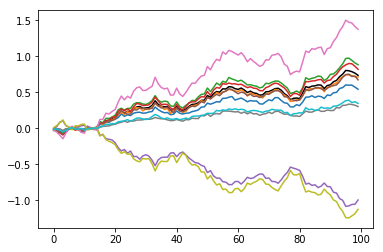

In [20]:
tr = 1
plt.figure()
plt.plot(xs[tr],'k')
plt.plot(ys[tr])

In [21]:
latent_ddm = LatentDDM(N)
latent_ddm.initialize(ys, inputs=us)

Initializing with an ARHMM using 25 steps of EM.


/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [22]:
# Create a variational posterior
from ssm.variational import SLDSMeanFieldVariationalPosterior
q_mf = SLDSMeanFieldVariationalPosterior(latent_ddm, ys, inputs=us, initial_variance=0.01)
# q_mf._params = [(np.random.randn(T, 1), np.zeros((T, 1))) for _ in range(N_samples)]
q_mf._params = [(xs[i], np.log(.1) * np.ones((T, 1))) for i in range(N_samples)]

In [23]:
q_mf_elbos = latent_ddm.fit(q_mf, ys, inputs=us, method="svi", num_iters=100, initialize=False, step_size=0.1)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


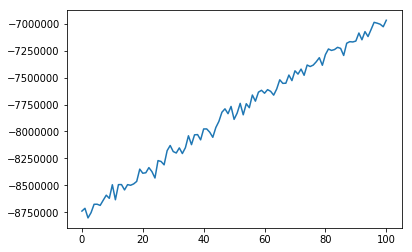

In [24]:
plt.plot(q_mf_elbos)

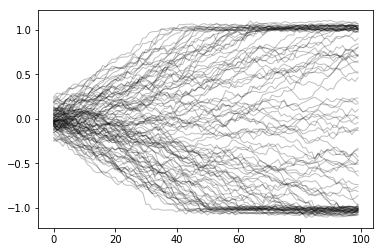

In [26]:
for xhat in q_mf.mean:
    plt.plot(xhat, '-k', lw=1, alpha=.25)

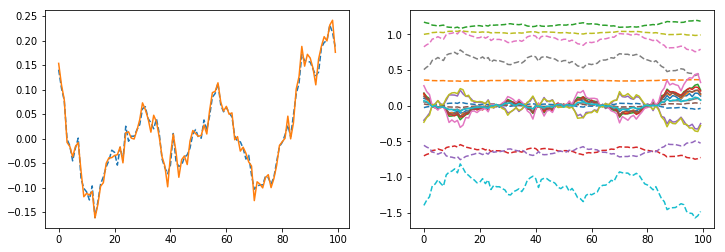

In [27]:
tr = 50
# tr += 1
yhat = latent_ddm.smooth(q_mf.mean[tr], ys[tr], input=us[tr])
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(q_mf.mean[tr],'--')
plt.plot(xs[tr])
plt.subplot(1,2,2)
plt.plot(yhat, '--')
plt.plot(ys[tr])

In [39]:
print(ddm.observations.beta)
print(ddm.observations._log_sigmasq)

1.0
[[-11.51292546]
 [ -9.21034037]
 [-11.51292546]]


In [29]:
print(latent_ddm.dynamics.beta)
print(latent_ddm.dynamics._log_sigmasq)

-0.2804976105776933
[[-11.42211877]
 [ -7.77608517]
 [-11.41911171]]


# Next Steps

The latent model didn't work out of the box -- the initial state trajectories are centered to be mean zero, which isn't a reasonable assumption for this model.  

Next up, let's try elaborations of the model. 

# Time-varying input

Here, the inputs are sequences of counts including zeros. This is intended to simulate the "Poisson clicks" task.

In [30]:
def generate_clicks(T=1.0,dt=0.01,rate_r=20,rate_l=20):
    """
    This function generates right and left 'clicks' from two Poisson processes with rates rate_r and rate_l
    over T seconds with bin sizes dt. The outputs are binned clicks into discrete time bins.
    """
    
    # number of clicks
    num_r = np.random.poisson(rate_r*T)
    num_l = np.random.poisson(rate_l*T)
    
    # click times
    click_time_r = np.sort(np.random.uniform(low=0.0,high=T,size=[num_r,1]))
    click_time_l = np.sort(np.random.uniform(low=0.0,high=T,size=[num_l,1]))
    
    # binned outputs are arrays with dimensions Tx1
    binned_r = np.histogram(click_time_r,np.arange(0.0,T+dt,dt))[0]
    binned_l = np.histogram(click_time_l,np.arange(0.0,T+dt,dt))[0]

    return binned_r, binned_l

In [31]:
ddm = DDM(sigmas=np.array([[1e-5], [1e-4], [1e-5]]))

# Sample state trajectories
T = 100 # number of time bins
trial_time = 1.0 # trial length in seconds
dt = 0.01 # bin size in seconds
N_samples = 100 

# input statistics
total_rate = 40 # the sum of the right and left poisson process rates is 40

us = []
zs = []
xs = []

for smpl in range(N_samples):

    # randomly draw right and left rates
    rate_r = np.random.randint(0,total_rate+1)
    rate_l = total_rate - rate_r

    # generate binned right and left clicks
    u_r, u_l = generate_clicks(T=trial_time,dt=dt,rate_r=rate_r,rate_l=rate_l)
    
    # input is sum of u_r and u_l
    u = 0.1*u_r - 0.1*u_l
    u = u[:,np.newaxis]
    z, x = ddm.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

Text(0,0.5,'$x(t)$')

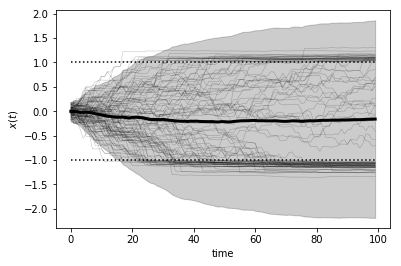

In [32]:
x_mean = np.mean(xs, axis=0)[:, 0]
x_std = np.std(xs, axis=0)[:, 0]

plt.fill_between(np.arange(T), x_mean-2*x_std, x_mean+2*x_std, color='k', edgecolor="none", alpha=0.2)
plt.plot(x_mean, '-k', lw=3)
for x in xs:
    plt.plot(x, '-k', lw=.5, alpha=.25)

plt.plot(np.ones(T), ':k')
plt.plot(-np.ones(T), ':k')

plt.xlabel("time")
plt.ylabel("$x(t)$")

In [33]:
test_ddm = DDM(beta=0.0, sigmas=np.ones((3, 1)))

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

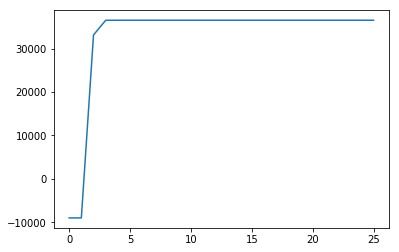

In [34]:
lls = test_ddm.fit(xs, inputs=us, num_em_iters=25)

plt.plot(lls)

In [37]:
print(ddm.observations.beta)
print(ddm.observations._log_sigmasq)

1.0
[[-11.51292546]
 [ -9.21034037]
 [-11.51292546]]


In [38]:
print(test_ddm.observations.beta)
print(test_ddm.observations._log_sigmasq)

0.9968286146989846
[[-11.52544713]
 [ -9.1956488 ]
 [-11.47879169]]


In [40]:
print("True: ", ddm.log_likelihood(xs, inputs=us))
print("Test: ", test_ddm.log_likelihood(xs, inputs=us))

True:  36561.96935845834
Test:  36564.38130054526


**Alternative parameterization of DDM with discrete input levels**
Here we consider the DDM for random dot motion (RDM). In RDM tasks, we typically have discrete input levels, and it is useful to consider learning a parameter $V_{z_t}$ for each input level. Let us say we have $C$ coherence levels. We can then parameterize with a one-hot input encoding the coherence level, such that $u_t \in \mathbb{R}^C$. Then, we can learn a $C$ dimensional vector of parameters $V_{z_t}$. The dynamics model in this case would be
$$
\begin{align*}
z_t &\sim p(x_{t-1}) \\
x_t &= x_{t-1} + V_{z_t}^\top u_t + \epsilon_t 
\end{align*}
$$

# Accumulator models
In the next section we develop accumulator models based on Brunton et al., Science 2013. The 1D accumulator model from Brunton 2013 has the form
$$
\begin{align*}
x_t &= 
\begin{cases}
0 & \text{if } |x_{t-1}|>B \\
(1 + \lambda) \, x_{t-1} + \left( \delta_{t,t_R} \eta_R c_t - \delta_{t,t_L} \eta_L c_t \right) + \epsilon_t & \text{otherwise}
\end{cases}
\end{align*}
$$
where $\epsilon_t \sim \mathcal{N}(0,\sigma_a^2)$, $\eta_R \sim \mathcal{N}(1, \sigma_s^2)$, $\eta_L \sim \mathcal{N}(1, \sigma_s^2)$ and 
$$
\begin{align*}
c_t &= \left[ \frac{\tau_\varphi - 1}{\tau_\varphi} + (\varphi - 1) (\delta_{t,t_R} + \delta_{t,t_L}) \right] c_{t-1} + \frac{1}{\tau_\varphi}
\end{align*}.
$$
The boundary $B$ acts in the same mechanism as the boundary in the DDM. The initial value $x_0$ comes from a zero-mean normal distribution with variance $\sigma_i^2$.

We can write the dynamics in the accumulation state (before boundary) with a coupled LDS
$$
\begin{align*}
x_0 & \sim \mathcal{N}(0, \sigma_i^2) \\
x_t & \sim \mathcal{N} \bigg((1 + \lambda) \, x_{t-1} + ( \delta_{t,t_R} -  \delta_{t,t_L} ) c_t , \, \sigma_a^2 + (\delta_{t,t_R}^2 + \delta_{t,t_L}^2)\,  c_t^2 \, \sigma_s^2 \bigg)\\
c_t & \sim \mathcal{N} \bigg(\left[ \frac{\tau_\varphi - 1}{\tau_\varphi} + (\varphi - 1) (\delta_{t,t_R} + \delta_{t,t_L}) \right] c_{t-1} + \frac{1}{\tau_\varphi}, \, \sigma_c^2 \bigg)
\end{align*}
$$

**Important note:** It would be nice to reference Brian DePasquale's poster that fits Bing's model to choice and small numbers of simultaneously recorded spike trains. (So we aren't first to envision fitting this model to choice + neural activity. Here we describe how this is possible in the state-space framework, which leads the way to powerful generalizations.)

Brunton, B. W., Botvinick, M. M., & Brody, C. D. (2013). Rats and humans can optimally accumulate evidence for decision-making. Science, 340(6128), 95-98.

## 1D Accumulator with decay

We can include accumulator drift via the modified dynamics
$$
\begin{align*}
x_t &= A_{z_t} x_{t-1} + V_{z_t} u_t + \epsilon_t.
\end{align*}
$$
Here, $A_\textsf{ramp}$ corresponds to $1 + \lambda$ from the (Brunton, 2013) accumulator model. We note that in the current implementation of this model, the $A_{z_t}$ are learned for each state.

In [92]:
class AccumulatorObservations(DDMObservations):
    def __init__(self, K, D, M=1, lags=1, beta=1.0, sigmas=1e-3 * np.ones((3, 1)), As=np.ones((3,1,1))):
        super(AccumulatorObservations, self).__init__(K, D, M, beta=beta, sigmas=sigmas)

        # learn diagonal autoregressive dynamics 
        self._As = As

    @property
    def params(self):
        return self.beta, self._log_sigmasq, self._As

    @params.setter
    def params(self, value):
        self.beta, self._log_sigmasq, self._As = value
        mask = np.reshape(np.array([0, 1, 0]), (3, 1, 1))
        self.Vs = mask * self.beta

    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        _Observations.m_step(self, expectations, datas, inputs, masks, tags, **kwargs)

    
def Accumulator(beta=1.0, sigmas=np.array([[1e-5], [1e-3], [1e-5]]), As=np.ones((3, 1, 1))):
    K, D, M = 3, 1, 1
    
    # Build the initial state distribution, the transitions, and the observations
    init_state_distn = InitialStateDistribution(K, D, M)
    init_state_distn.log_pi0 = np.log([0.01, 0.98, 0.01])
    transition_distn = DDMTransitions(K, D, M)
    observation_distn = AccumulatorObservations(K, D, M, beta=beta, sigmas=sigmas, As=As)
    
    return BaseHMM(K, D, M, init_state_distn, transition_distn, observation_distn)

In [93]:
As = np.array([[1.0,0.95,1.0]]).reshape((3,1,1))
accum = Accumulator(sigmas=[[1e-5], [1e-3], [1e-5]], As=As)

In [95]:
# Sample state trajectories
T = 100 # number of time bins
trial_time = 1.0 # trial length in seconds
dt = 0.01 # bin size in seconds
N_samples = 100 

# input statistics
total_rate = 40 # the sum of the right and left poisson process rates is 40

us = []
zs = []
xs = []

for smpl in range(N_samples):

    # randomly draw right and left rates
    rate_r = np.random.randint(0,total_rate+1)
    rate_l = total_rate - rate_r

    # generate binned right and left clicks
    u_r, u_l = generate_clicks(T=trial_time,dt=dt,rate_r=rate_r,rate_l=rate_l)
    
    # input is sum of u_r and u_l
    u = 0.1*u_r - 0.1*u_l
    u = u[:,np.newaxis]
    z, x = accum.sample(T, input=u)
    
    us.append(u)
    zs.append(z)
    xs.append(x)

Text(0,0.5,'$x(t)$')

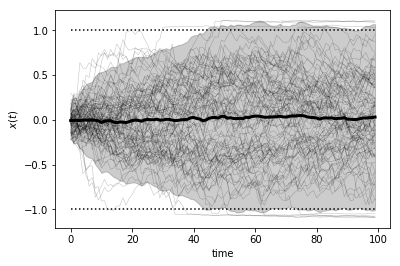

In [96]:
x_mean = np.mean(xs, axis=0)[:, 0]
x_std = np.std(xs, axis=0)[:, 0]

plt.fill_between(np.arange(T), x_mean-2*x_std, x_mean+2*x_std, color='k', edgecolor="none", alpha=0.2)
plt.plot(x_mean, '-k', lw=3)
for x in xs:
    plt.plot(x, '-k', lw=.5, alpha=.25)

plt.plot(np.ones(T), ':k')
plt.plot(-np.ones(T), ':k')

plt.xlabel("time")
plt.ylabel("$x(t)$")

In [99]:
test_accum = Accumulator(beta=0.0, sigmas=np.ones((3, 1)), As=np.ones((3,1,1)))

/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/davidzoltowski/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

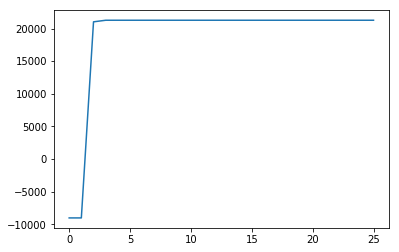

In [100]:
lls = test_accum.fit(xs, inputs=us, num_em_iters=25)

plt.plot(lls)

In [101]:
print(accum.observations.beta)
print(accum.observations._log_sigmasq)
print(accum.observations._As)

1.0
[[-11.51292546]
 [ -6.90775528]
 [-11.51292546]]
[[[1.  ]]

 [[0.95]]

 [[1.  ]]]


In [102]:
print(test_accum.observations.beta)
print(test_accum.observations._log_sigmasq)
print(test_accum.observations._As)

1.0023988594068312
[[-11.48908564]
 [ -6.91062962]
 [-11.56561943]]
[[[0.99988589]]

 [[0.94967238]]

 [[1.00038348]]]


In [103]:
print("True: ", accum.log_likelihood(xs, inputs=us))
print("Test: ", test_accum.log_likelihood(xs, inputs=us))

True:  21264.599148797635
Test:  21267.124607172467


# Multi-dimensional Accumulator

Accumulation to bound with 2 input dimensions: let $u_t \in \mathbb{R}^2$ and $V_{z_t} \in \mathbb{R}^2$.
$$
\begin{align*}
x_t &= (1 + \lambda) x_{t-1} + V_{z_t}^\top u_t + \epsilon_t 
\end{align*}
$$

In [ ]:
class MultiAccumulatorObservations(AutoRegressiveDiagonalNoiseObservations):
    def __init__(self, K, D, M=0, lags=1, sigmas=1e-3 * np.ones((3, 1))):
        assert K == 3
        assert D == M
        super(MultiAccumulatorObservations, self).__init__(K, D, M)
        
        # dynamics matrix for each state
        # TODO: could restrict this to be diagonal
        self._As = 1.0 * np.array([
                            np.column_stack([np.eye(D), np.zeros((D, (lags-1) * D))])
                            for _ in range(K)])

        # set input accumulator params, one for each dimension
        self._betas = np.ones(D)
        
        # set noise variances, which are initialized in the AR constructor
        self._log_sigmasq = np.log(sigmas)
        
        # Set the remaining parameters to fixed values
        self.bs = np.zeros((3, D))
        self.mu_init = np.zeros((3, D))
        self._log_sigmasq_init = np.log(.01 * np.ones((3, D)))

        # They only differ in their input 
        self.Vs[0] *= np.zeros((D,D))            # left bound
        self.Vs[1] = np.diag(self._betas)         # ramp
        self.Vs[2] *= np.zeros((D,D))            # right bound
        
    @property
    def params(self):
        return self._betas, self._log_sigmasq
        
    @params.setter
    def params(self, value):
        self.beta, self._log_sigmasq = value
        mask = np.array([np.zeros((D,D)), np.eye(D), np.zeros((D,D))])
        self.Vs = mask * self._betas
        
    def initialize(self, datas, inputs=None, masks=None, tags=None):
        pass

#     def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
#         _Observations.m_step(self, expectations, datas, inputs, masks, tags, **kwargs)
      
# Transition model
class MultiAccumulatorTransitions(RecurrentOnlyTransitions):
    #TODO
    pass 

def MultiAccumulator(D=2, M=2, sigmas=np.array([[1e-5], [1e-3], [1e-5]])):
    #TODO
    pass

**Other Models**
1. Include adaptation $c_t$
2. Add input-dependent variance from Bing's model
3. Time-lag in inputs - some mechanism to incorporate time-delays from stimulus presentation until neural response.
4. Gain modulation. Add an initial dimension
$$
g_t \sim \mathcal{N}(g_{t-1}, \sigma_g^2)
$$
that modulates the mapping from latent state to neural responses. This could vary slowly within trials and/or more rapidly across trials. 